This notebook helps to figure out in which range the measurements are in the world frame.
It plots vehicle locations in world map for specified frame sequence.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from vod.configuration import KittiLocations
from vod.frame import FrameDataLoader
from vod.frame import FrameTransformMatrix
from vod.frame import homogeneous_transformation
from config import DATASET_PATH
from config import OUTPUT_DIR

In [2]:
kitti_locations = KittiLocations(root_dir=DATASET_PATH,
                                output_dir=OUTPUT_DIR,
                                frame_set_path="",
                                pred_dir="",
                                )

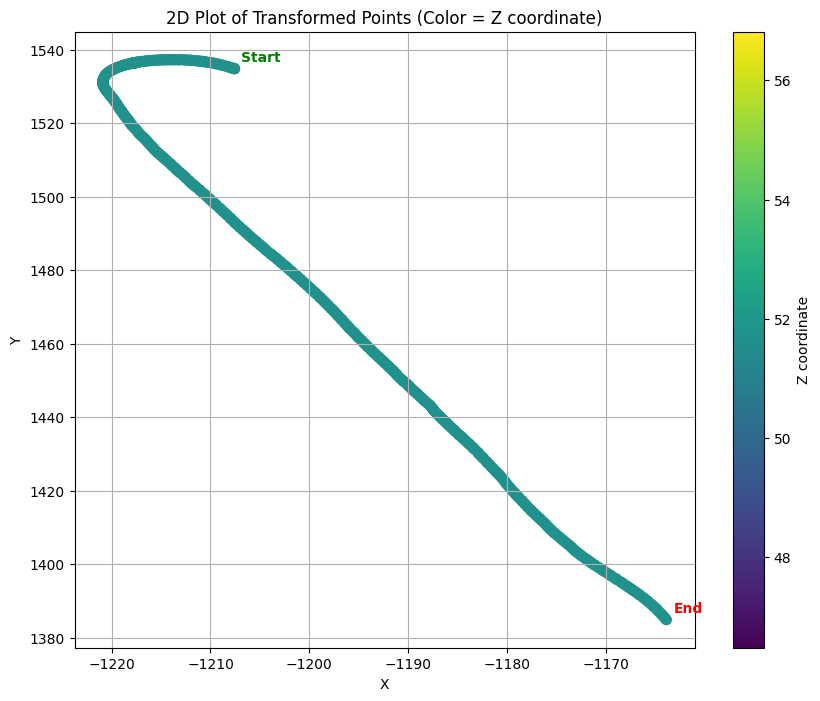

In [3]:
'''
Scenes:
00000-00543
00544-01311
01312-...
'''

# -- Collect Transformed Points --
all_transformed_points = []

for i in range(10, 540):  #the stop value is exclusive
    frame_number = f"{i:05d}"
    try:
        frame_data = FrameDataLoader(kitti_locations=kitti_locations, frame_number=frame_number)
        transforms = FrameTransformMatrix(frame_data)
        odom2cam, map2cam, utm2cam = transforms.get_world_transform()
        
        # Apply transformation to origin point
        coordinate_lidar = np.array([[0, 0, 50, 1]])
        coordinate_camera = homogeneous_transformation(coordinate_lidar, transforms.t_camera_lidar)
        coordinate_map = homogeneous_transformation(coordinate_camera, map2cam).round(2)
        point_transformed = coordinate_map
        all_transformed_points.append(point_transformed[0][:3])  # extract x,y,z
    except Exception as e:
        print(f"Error on frame {frame_number}: {e}")

# -- Convert to NumPy Array --
points_np = np.array(all_transformed_points)
x, y, z = points_np[:, 0], points_np[:, 1], points_np[:, 2]

# -- 2D Scatter Plot (X vs Y, color by Z) --
plt.figure(figsize=(10, 8))
sc = plt.scatter(x, y, c=z, cmap='viridis', s=50)
# Label start point
plt.annotate("Start", (x[0], y[0]), textcoords="offset points", xytext=(5, 5), ha='left', color='green', fontsize=10, weight='bold')
# Label end point
plt.annotate("End", (x[-1], y[-1]), textcoords="offset points", xytext=(5, 5), ha='left', color='red', fontsize=10, weight='bold')

plt.colorbar(sc, label='Z coordinate')
plt.xlabel("X")
plt.ylabel("Y")
plt.title("2D Plot of Transformed Points (Color = Z coordinate)")
#plt.axis("equal")
plt.grid(True)
# Set fixed axis ranges
#plt.xlim([-1300, -1100])   # Adjust to your desired range
#plt.ylim([1200, 1600])    # Adjust to your desired range
plt.show()